<a href="https://colab.research.google.com/github/gannannavelorange/575/blob/master/src/IB_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!git clone https://github.com/gannannavelorange/575

Cloning into '575'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 609 (delta 30), reused 0 (delta 0), pack-reused 548
Receiving objects: 100% (609/609), 2.87 MiB | 2.70 MiB/s, done.
Resolving deltas: 100% (254/254), done.


In [20]:
cd 575/src/data_IB_project

/content/575/src/data_IB_project/575/src/data_IB_project


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import t

# VaR and ES

In [0]:
#VaR
def VaRnorm(alpha,mu,sigma):
  VaR=mu+sigma*norm.ppf(alpha)
  ES=mu+sigma*norm.pdf(norm.ppf(alpha))/(1-alpha)
  return VaR,ES


In [0]:
def VaRt(alpha,mu,sigma,v):
  VaR=mu+sigma*t.ppf(alpha,v)
  E=t.pdf(t.ppf(alpha,v),v)/(1-alpha)*(v+(t.ppf(alpha,v))**2)/(v-1)
  ES=mu+sigma*E
  return VaR,ES

# Stock&ETF

In [0]:
#using WEEKLY log return
names=['CAT','DIA','HD','MSFT','NKE','NVDA','PG','TM','VIG','VOO','WMT','GOOG','CHEF','SPB','ORCL']
def getData(N):  
    mu=np.zeros(15)
    Is=[i for i in range(15)]
    Rows=[]
    for name,i in zip(names,Is):
        with open(name+'.csv') as file:
            reader=csv.reader(file)
            rows=[row[2] for row in reader] 
        mu[i]=np.mean([float(row) for row in rows[1+N:53+N]]) #mean
        Rows.append([float(row) for row in rows[1+N:53+N]])
    Sigma=np.cov(np.array(Rows)) #covariance matrix
    return mu,Sigma,rows

In [0]:
def getdata1(M,N):
  with open(M+'.csv') as file:
      reader=csv.reader(file)
      rows=[row for row in reader]
      col0=[row[0] for row in rows[1:62]]
      col0=[float(c) for c in col0] # port value
      col1=[row[1] for row in rows[1+N:53+N]]
      col1=[float(c) for c in col1]  # port loss
      
  return col0,col1

In [0]:
#linearized loss mean&variance
def lin_loss(Vt,Wt,mu,omega):
  mean=-Vt*(np.dot(Wt,mu))
  variance=(Vt**2)*(np.dot(np.dot(Wt,omega),Wt))
  return mean,variance

In [0]:
#rolling window for linearized loss assuming log return change follows Normal distribution 
def stock_norm():
  MU=[]
  VAR=[]
  for i in range(0,10):
    data= getData(i+1)
    mu=data[0]
    Sigma=data[1]
    vt=getdata1('PORT_VALUE',i)[0]
    wt=np.ones(15)*(1/15)
    linloss=lin_loss(vt[i+51]*400000,wt,mu,Sigma)
    MU.append(linloss[0])
    VAR.append(linloss[1])
  return MU,VAR
 #print(MU)
 #print(VAR)

In [0]:
#rolling window  assuming portfolio loss follows t distribution 
def stock_t():
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    data=np.array(getdata1('PORT_VALUE',i)[1])*400000
    T=t.fit(data)
    df.append(T[0])
    mu.append(T[1])
    sigma.append(T[2])
  return df,mu,sigma
#print(T_df)
#print(T_mu)
#print(T_sigma)

In [0]:
# plot VaR and ES vs time
def plot_N(name):
  N1=VaRnorm(0.9,name[0],np.sqrt(name[1]))
  N2=VaRnorm(0.95,name[0],np.sqrt(name[1]))
  N3=VaRnorm(0.99,name[0],np.sqrt(name[1]))
  #x=np.linspace(1,10,10)
  x=['2020/02/14','2020/02/21','2020/02/28','2020/03/06','2020/03/13','2020/03/20','2020/03/27','2020/04/3','2020/04/10','2020/04/17']
  plt.plot(x,N1[0],'orange',label="VaR_0.9")
  plt.plot(x,N1[1],'blue',label="ES_0.9")
  plt.plot(x,N2[0],'yellow',label="VaR_0.95")
  plt.plot(x,N2[1],'green',label="ES_0.95")
  plt.plot(x,N3[0],'red',label="VaR_0.99")
  plt.plot(x,N3[1],'purple',label="ES_0.99")
  plt.xlabel('time')
  plt.xticks(rotation=45)
  #plt.title('Normal:stock&ETF:var and ES vs time')
  #plt.title('Normal:Put option DJX:var and ES vs time')
  #plt.title('Normal:Call option CAT:var and ES vs time')
  #plt.title('Normal:Call option VIG:var and ES vs time')
  plt.title('Normal:Bond20-year:var and ES vs time')
  #plt.title('Normal:Bond30-year:var and ES vs time')
  plt.legend()
  plt.show()
  return N1[0],N1[1],N2[0],N2[1],N3[0],N3[1]
  
def plot_T(name):
  N1_var=[]
  N1_es=[]
  N2_var=[]
  N2_es=[]
  N3_var=[]
  N3_es=[]
  for i in range(0,10):
    T1=VaRt(0.9,name[1][i],name[2][i],name[0][i])
    T2=VaRt(0.95,name[1][i],name[2][i],name[0][i])
    T3=VaRt(0.99,name[1][i],name[2][i],name[0][i])
    N1_var.append(T1[0])
    N1_es.append(T1[1])
    N2_var.append(T2[0])
    N2_es.append(T2[1])
    N3_var.append(T3[0])
    N3_es.append(T3[1])
  #x=np.linspace(1,10,10)
  x=['2020/02/14','2020/02/21','2020/02/28','2020/03/06','2020/03/13','2020/03/20','2020/03/27','2020/04/3','2020/04/10','2020/04/17']
  plt.plot(x,N1_var,'orange',label="VaR_0.9")
  plt.plot(x,N1_es,'blue',label="ES_0.9")
  plt.plot(x,N2_var,'yellow',label="VaR_0.95")
  plt.plot(x,N2_es,'green',label="ES_0.95")
  plt.plot(x,N3_var,'red',label="VaR_0.99")
  plt.plot(x,N3_es,'purple',label="ES_0.99")
  plt.xlabel('time')
  plt.xticks(rotation=45)
  #plt.title('T:stock&ETF:var and ES vs time')
  #plt.title('T:Put option DJX:var and ES vs time')
  #plt.title('T:Call option CAT:var and ES vs time')
  #plt.title('T:Call option VIG:var and ES vs time')
  plt.title('T:Bond20-year:var and ES vs time')
  #plt.title('T:Bond30-year:var and ES vs time')
  plt.legend()
  plt.show()

([-2184.4121072601165, -1089.562834286747, -1128.2445046939927, 99.03518540788191, 1772.40067129909, 529.4705256889033, 962.2148752578879, 217.8220329882339, 104.49368198248186, 110.41358889778817], [78737101.1392646, 142247199.01808247, 112670241.3850035, 163344498.2689849, 283187350.1667939, 264175762.94001532, 337332841.377919, 364350910.5106507, 436534407.8471075, 483075639.10686916])


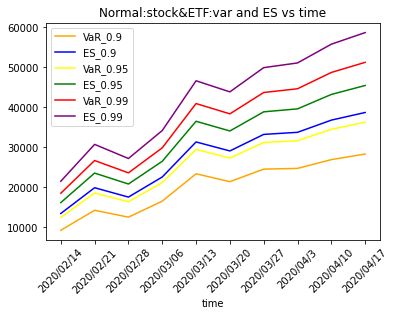

(array([ 9187.29842521, 14195.17335232, 12474.94342312, 16478.07132349,
       23338.56997899, 21359.14921153, 24499.98936795, 24680.05033622,
       26880.47065353, 28277.6120696 ]), array([13388.24437667, 19841.67221623, 17500.2434507 , 22528.82730753,
       31305.56064263, 29054.06494965, 33195.33191816, 33716.90531602,
       36772.07242566, 38683.15994947]), array([12411.02034888, 18528.18367663, 16331.25818154, 21121.30047852,
       29452.27931132, 27264.07368626, 31172.62137437, 31614.75215244,
       34471.0880672 , 36262.62144981]), array([16118.84902497, 23511.88274085, 20766.67624296, 26461.80397675,
       36484.08519173, 34055.74145907, 38847.28342158, 39590.83906785,
       43201.58951305, 45446.74075655]), array([18458.18654632, 26656.19042993, 23565.06333158, 29831.22616632,
       40920.58125881, 38340.72996352, 43689.36930502, 44623.09946194,
       48709.82395338, 51241.17107459]), array([21465.08076968, 30697.76225977, 27162.00216349, 34162.15149256,
       46623.

In [60]:
N=stock_norm()
print(N)
a=plot_N(N)
print(a)


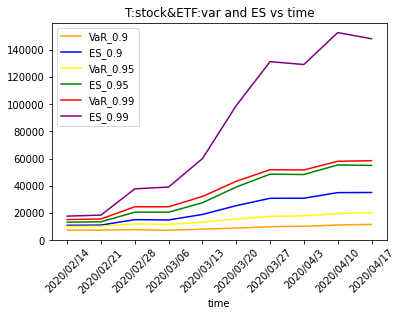

None


In [61]:
T=stock_t()
b=plot_T(T)
print(b)


# Options

In [0]:
def getdata2(M,N):
  with open(M+'.csv') as file:
      reader=csv.reader(file)
      rows=[row for row in reader]
      col0=[row[1] for row in rows[1:62]]
      col0=[float(c) for c in col0] # stock value
      col1=[row[2] for row in rows[1+N:53+N]]
      col1=[float(c) for c in col1]  # log return
      col2=[row[3] for row in rows[1+N:53+N]]
      col2=[float(c) for c in col2]  # net stock return
  return col0,col1,col2


In [0]:
def origin_price(S,K,r,sigma,t):
  d1=(np.log(S/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  d2=d1-sigma*np.sqrt(t)
  callprice=S*norm.cdf(d1)-K*np.exp(-r*t)*norm.cdf(d2)
  putprice=-S*norm.cdf(-d1)+K*np.exp(-r*t)*norm.cdf(-d2)
  return callprice,putprice

In [0]:
def delta(S,K,r,sigma,t):
  d1=(np.log(S/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  delta_C=norm.cdf(float(d1))
  delta_P=norm.cdf(float(d1))-1
  return delta_C,delta_P


In [0]:
#OP=[9.5,9,11.21,39.96,38.84,64.99,102.26,78.84,83.26,57.34,51.95] 

In [0]:
'''
def option_N(M,K,share,type,t):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  MU=[]
  VAR=[]
  L=[]
  d=[]
  op=[]
  LL=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    #loss=(-1)**(type)*np.array(data[2]) #stock loss
    vt=data[0]
    wt=1
    linloss=lin_loss(vt[i+51]*share,wt,mu,variance)
    OP=origin_price(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]  #t=(2020/06/18-2020/02/14)/250
    Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    MU.append((-1)**(type+1)*leverage*linloss[0])
    VAR.append(leverage**2*linloss[1])
    L.append(leverage)
    d.append(Delta)
    op.append(OP)
    LL.append(linloss[1])
  return MU,VAR,d,op,L,LL

In [0]:

def option_N(M,K,share,type,t):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  MU=[]
  VAR=[]
  Loss=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    #loss=(-1*share)**(type)*np.array(data[2]) #stock loss
    #Norm=norm.fit(loss)
    vt=data[0]
    wt=1
    #linloss=lin_loss(vt[i+51]*share,wt,mu,variance)
    OP=origin_price(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type] #t=(2020/06/18-2020/02/14)/250
    OP1=origin_price(vt[i+51-1],K,0.02,0.1,(t+7-7*i)/250)[type]
    loss=(OP1-OP)*((-1)**(type+1))
    Loss.append(loss)
    Norm=norm.fit(Loss)
    #Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    #leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    MU.append(Norm[0])
    VAR.append(Norm[1])
    
  return MU,VAR

In [0]:
'''
def option_N(M,K,share,type,t):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  MU=[]
  VAR=[]
  Loss=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    #loss=(-1*share)**(type)*np.array(data[2]) #stock loss
    #Norm=norm.fit(loss)
    vt=data[0]
    wt=1
    for j in range(0,51):
    #linloss=lin_loss(vt[i+51]*share,wt,mu,variance)
     OP=origin_price(vt[j+i+1],K,0.02,0.1,(t-7*i)/250)[type] #t=(2020/06/18-2020/02/14)/250
     OP1=origin_price(vt[j+i],K,0.02,0.1,(t+7-7*i)/250)[type]
     loss=(OP1-OP)*((-1)**(type+1))
     Loss.append(loss)
    Norm=norm.fit(Loss)
    #Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    #leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    MU.append(Norm[0])
    VAR.append(Norm[1])
    
  return MU,VAR

In [0]:
def option_T(M,K,share,type,T):  #type=0 for call, type=1 for put, t=maturity date-2020/02/14
  DF=[]
  MU=[]
  VAR=[]
  Loss=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    mu=np.mean(data[1])  #mu=mean of stock log return
    variance=np.var(data[1]) #variance of stock log return
    #loss=(-1*share)**(type)*np.array(data[2]) #stock loss
    #Norm=norm.fit(loss)
    vt=data[0]
    wt=1
    #linloss=lin_loss(vt[i+51]*share,wt,mu,variance)
    OP=origin_price(vt[i+51],K,0.02,0.1,(T-7*i)/250)[type] #t=(2020/06/18-2020/02/14)/250
    OP1=origin_price(vt[i+51-1],K,0.02,0.1,(T+7-7*i)/250)[type]
    loss=(OP1-OP)*((-1)**(type+1))
    Loss.append(loss)
    Norm=t.fit(Loss)
    #Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    #leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    DF.append(Norm[0])
    MU.append(Norm[1])
    VAR.append(Norm[2])
    
  return DF,MU,VAR

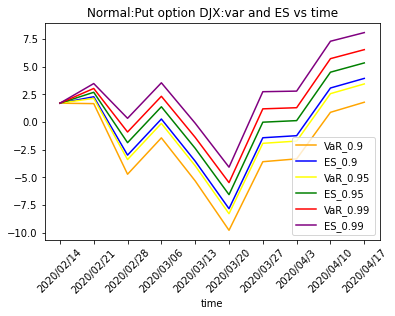

(array([ 1.69691931,  1.65791262, -4.72375935, -1.43673741, -5.32625184,
       -9.78842095, -3.59090996, -3.33564436,  0.87225071,  1.78413517]), array([ 1.69691931,  2.27872282, -2.9944183 ,  0.26610433, -3.54278191,
       -7.83689915, -1.42628735, -1.24021606,  3.07034292,  3.93728461]), array([ 1.69691931,  2.13430996, -3.39669761, -0.13001071, -3.95765268,
       -8.29086214, -1.92982185, -1.72765458,  2.55902272,  3.436419  ]), array([ 1.69691931,  2.68224794, -1.87035083,  1.37294731, -2.3835308 ,
       -6.56841473, -0.01928792,  0.12180723,  4.49909751,  5.33682651]), array([ 1.69691931,  3.02795213, -0.90735049,  2.32119126, -1.39038826,
       -5.48169088,  1.18610319,  1.28866681,  5.72312649,  6.53582868]), array([ 1.69691931,  3.47230695,  0.33045301,  3.54002746, -0.11384115,
       -4.08485795,  2.73546643,  2.78850311,  7.29644612,  8.07697981]))


In [44]:
djx=option_N('DIA',293,100,1,125)
c=plot_N(djx)
print(c)


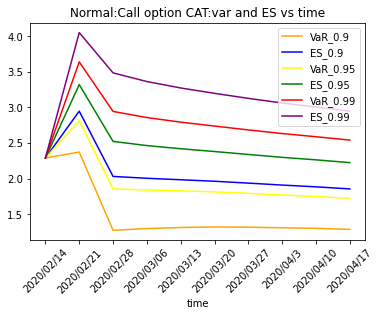

(array([2.2884838 , 2.37270679, 1.27417867, 1.29783386, 1.31341091,
       1.32054896, 1.31754612, 1.30948376, 1.30157693, 1.28699518]), array([2.2884838 , 2.94653654, 2.03037598, 2.00425204, 1.98365926,
       1.96259308, 1.93645151, 1.90888772, 1.88429464, 1.85496128]), array([2.2884838 , 2.81305227, 1.85446936, 1.83992505, 1.82774609,
       1.81324078, 1.79248174, 1.76945437, 1.74874285, 1.72284101]), array([2.2884838 , 3.31952448, 2.52190239, 2.46342214, 2.41931906,
       2.37992019, 2.33873851, 2.29849883, 2.26305973, 2.22413787]), array([2.2884838 , 3.63906714, 2.9429982 , 2.85679796, 2.79255336,
       2.73744869, 2.68338198, 2.63228274, 2.58755174, 2.5404153 ]), array([2.2884838 , 4.04979495, 3.48425851, 3.36242806, 3.27229434,
       3.19700203, 3.12637341, 3.06131571, 3.00464125, 2.94694612]))


In [49]:
cat=option_N('CAT',135,200,0,91)
d=plot_N(cat)
print(d)

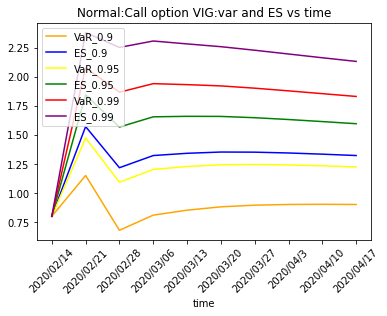

(array([0.80218429, 1.15272918, 0.68248519, 0.8124633 , 0.85470397,
       0.88362033, 0.89782589, 0.90390319, 0.90523097, 0.90367778]), array([0.80218429, 1.57210647, 1.21925606, 1.32359205, 1.34287478,
       1.35373953, 1.35266556, 1.34559242, 1.33543604, 1.32372864]), array([0.80218429, 1.47455093, 1.09439243, 1.20469328, 1.22931649,
       1.2443804 , 1.24686076, 1.24284667, 1.23536174, 1.22601641]), array([0.80218429, 1.84470069, 1.56815582, 1.6558245 , 1.66018461,
       1.65931586, 1.64831023, 1.63268934, 1.61506829, 1.59676067]), array([0.80218429, 2.078235  , 1.86706189, 1.9404515 , 1.93202726,
       1.9211063 , 1.90159212, 1.87864827, 1.85463215, 1.83067007]), array([0.80218429, 2.378411  , 2.25126422, 2.30630008, 2.28144332,
       2.25760163, 2.22715088, 2.1947944 , 2.16255831, 2.13132819]))


In [51]:
vig=option_N('VIG',131,200,0,91)
e=plot_N(vig)
print(e)

In [0]:
'''
def option_t(M,K,share,type,t):
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    data= getdata2(M,i+1)
    nr=np.array(data[2])*share
    T=ss.t.fit(nr)
    #df.append(T[0])
    #mu.append(T[1])
    #sigma.append(T[2])
    vt=data[0]
    wt=1
    OP=origin_price(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]  #t=(2020/06/18-2020/02/14)/250
    Delta=delta(vt[i+51],K,0.02,0.1,(t-7*i)/250)[type]    #strike=100 type=0:call type=1: put
    leverage=Delta*vt[i+51]/OP
    #leverage=Delta*vt[i+51]/OP[i]
    df.append(T[0])
    mu.append((-1)**(type+1)*leverage*T[1])
    sigma.append(leverage**2*T[2])
    #L.append(leverage)
    #d.append(Delta)
    #op.append(OP)

  return df,mu,sigma

In [0]:
vig2=option_T('VIG',131,200,0,91)
e=plot_T(vig2)


In [0]:
a=getdata2('VIG',0)[2]
b=np.array(a)*200
print(b)


# Bonds

In [0]:
c1=1.75/100*1000/2
c2=6/100*1000/2
n1=15
n2=11
#r=-0.115/100
#r=-0.098/100/2
F=1000

In [0]:
def getdata3(M):
  with open(M+'.csv') as file:
      reader=csv.reader(file)
      rows=[row for row in reader]
      col0=[row[1] for row in rows[1:62]]
      col0=[float(c) for c in col0]  # weekly interest rate 
      
  return col0

In [0]:
def bond(C,r,F,t,N):
  price=C*np.exp(-t/182*r)*(1-np.exp(-(N+1)*r))/(1-np.exp(-r))+F*np.exp((-t/182+N)*r)
  return price

In [50]:
price1=[]
ir=getdata3('bond1')
for i in range(0,62):
  #price1.append(price(c1,ir[i]/200,F,365+152-7*i,n1))
   price1=bond(c1,ir[i]/200,F,365+152-7*i,n1)
   print(price1)


1179.8749302600258
1184.5435033975716
1179.8611200160199
1175.511751827893
1169.6764097398834
1169.341047373335
1172.7239478359022
1172.8554356031245
1173.9712512003887
1169.467309882223
1174.4758489507858
1172.5036496064226
1171.9273712110523
1171.3461983861782
1162.1912959135943
1159.23719967455
1165.6646631521692
1158.0348502934226
1157.5739762850055
1159.7721394192135
1158.6584013586587
1157.2398151062307
1159.8184680123543
1154.5567896067896
1146.9732715161986
1143.3135401198713
1142.3740996067163
1140.475971219812
1144.1904334534556
1158.190991682132
1152.7346622625041
1152.9653584199873
1144.8614248515325
1154.9171366478358
1152.9829368474807
1152.905181669538
1151.95232758927
1157.0848894278006
1156.3870218062978
1152.837939486041
1153.644150841026
1151.7850413044473
1149.7264311855556
1151.6760697922687
1151.4602471065796
1143.55981878834
1147.1605737157963
1147.1208374842531
1140.0640839337643
1131.8761017729655
1134.7270999531465
1133.6809999339876
1129.1619686139466
1121.25

IndexError: ignored

In [53]:
price2=[]
ir2=getdata3('bond3.625')
for i in range(0,62):
  #price1.append(price(c2,ir2[i]/200,F,365+182-7*i,n2))
   price2=bond(c2,ir2[i]/200,F,365+182-7*i,n2)
   print(price2)

1379.1612904173303
1381.504296085739
1379.5591827905146
1377.5863599141926
1375.0439466987584
1374.921341963814
1376.4519184366009
1376.613396305838
1377.340322143071
1375.2299501971077
1377.6741027352216
1376.9691077912873
1376.5426047861704
1376.401149794934
1371.8234259955598
1370.4538308632334
1374.1379173277476
1370.0436420963738
1370.1332248016056
1371.1390697518552
1370.620225108337
1369.7818398344134
1371.118134826534
1368.378052206305
1364.3571696825122
1362.1905108268058
1361.89250658624
1360.9529175658088
1362.8894996983872
1370.456359993055
1367.8796189731188
1367.9427533355456
1363.6499235443325
1369.0887406846464
1368.132173907129
1368.1953199262061
1367.5641593116134
1370.4271354194616
1370.1519271087548
1367.737745778434
1368.1532115337814
1367.493522132675
1366.462649380721
1367.603977993197
1367.6592092690862
1362.9237886579915
1365.1655283040523
1365.2022832553594
1361.4910022246245
1356.6388801645346
1358.1167151338127
1357.7252777769131
1355.4299490775413
1349.7074

IndexError: ignored

In [0]:
change1=[-4.668573138,4.682383382,4.349368188,5.835342088,0.335362367,-3.382900463,-0.131487767,-1.115815597,4.503941318,-5.008539069,1.972199344,0.576278395,0.581172825,9.154902473,2.954096239,-6.427463478,7.629812859,0.460874008,-2.198163134,1.113738061,1.418586252,-2.578652906,5.261678406,7.583518091,3.659731396,0.939440513,1.898128387,-3.714462234,-14.00055823,5.45632942,-0.230696157,8.103933568,-10.0557118,1.9341998,0.077755178,0.95285408,-5.132561839,0.697867622,3.54908232,-0.806211355,1.859109537,2.058610119,-1.949638607,0.215822686,7.900428318,-3.600754927,0.039736232,7.05675355,8.187982161,-2.85099818,1.046100019,4.51903132,7.903259478,13.16607817,-51.70245549,-20.28135685,45.34336564,14.75785748,3.49401862,-7.470250461]
change2=[-2.343005668,1.945113295,1.972822876,2.542413215,0.122604735,-1.530576473,-0.161477869,-0.726925837,2.110371946,-2.444152538,0.704994944,0.426503005,0.141454991,4.577723799,1.369595132,-3.684086465,4.094275231,-0.089582705,-1.00584495,0.518844644,0.838385274,-1.336294992,2.74008262,4.020882524,2.166658856,0.298004241,0.93958902,-1.936582133,-7.566860295,2.57674102,-0.063134362,4.292829791,-5.43881714,0.956566778,-0.063146019,0.631160615,-2.862976108,0.275208311,2.41418133,-0.415465755,0.659689401,1.030872752,-1.141328612,-0.055231276,4.735420611,-2.241739646,-0.036754951,3.711281031,4.85212206,-1.477834969,0.391437357,2.295328699,5.722459023,7.979227515,-30.52251217,-11.88657413,24.92814353,9.071354289,1.635429487,-4.283898783]

In [0]:
def bond_N(M):
  mu=[]
  sigma=[]
  for i in range(0,10):
    a=[]
    for j in range(0+i,51+i):
      a.append(M[j])
    N=norm.fit(a)
    mu.append(N[0])
    sigma.append(N[1]**2)
  return mu,sigma

def bond_T(M):
  df=[]
  mu=[]
  sigma=[]
  for i in range(0,10):
    a=[]
    for j in range(0+i,51+i):
      a.append(M[j])
    N=t.fit(a)
    df.append(N[0])
    mu.append(N[1])
    sigma.append(N[2])
  return df,mu,sigma

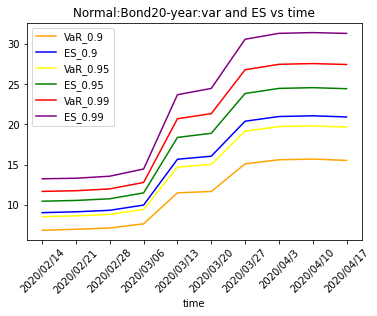

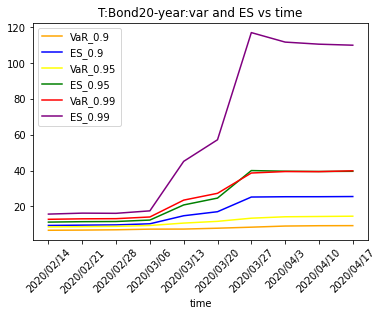

In [58]:
b1=bond_N(change1)
#print(bond_N(change1))
B1=plot_N(b1)
b11=bond_T(change1)
B11=plot_T(b11)


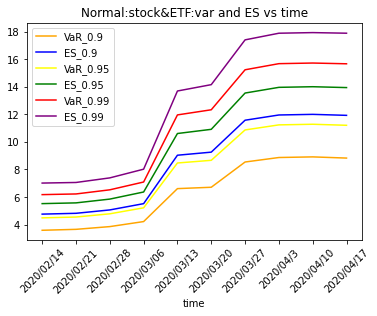

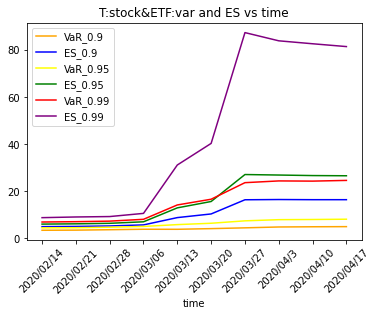

In [56]:
b2=bond_N(change2)
#print(bond_N(change1))
B2=plot_N(b2)
b22=bond_T(change2)
B22=plot_T(b22)

In [8]:
p=c*(np.exp(-r)-np.exp(-17*r))/(1-np.exp(-r))+F*np.exp(-16*r)
print(p)

1148.4554879057312


In [0]:
p2=c*(1-(1+r)**(-n))/r+F/((1+r)**n)
print(p2)